In [1]:
# Optimize Sigma Variation with ShareParameters

In [2]:
from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list

#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

# Import my own functions
from desc.fns_simp import (#data_eval, 
                           #_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           #plot_xy,
                           #surf_int
                          )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100 80GB PCIe (id=0), with 80.00 GB available memory

In [4]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization_fd,
    CoilThicknessRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [5]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [6]:
G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [7]:
eq = eq_QA

R0 = 1.0
a = 0.3

surf = FourierRZToroidalSurface(R_lmn=[R0,a], 
                                Z_lmn=[-a],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP
                               )
surf.change_resolution(N=eq.N)

eq.axis.R_n = eq_QA.axis.R_n + 0.5*(eq_QH.axis.R_n - eq_QA.axis.R_n)
eq.axis.Z_n = eq_QA.axis.Z_n + 0.5*(eq_QH.axis.Z_n - eq_QA.axis.Z_n)

######
for coef, mode in zip(eq.axis.R_n, eq.axis.R_basis.modes):
    n = mode[-1]
    surf.R_lmn=surf.R_lmn.at[surf.R_basis.get_idx(M=0,N=n)].set( coef)
for coef, mode in zip(eq.axis.Z_n, eq.axis.Z_basis.modes):
    n = mode[-1]
    surf.Z_lmn=surf.Z_lmn.at[surf.Z_basis.get_idx(M=0,N=n)].set( coef)

In [8]:
surf1 = surf

surf1.change_resolution(M=16,N=8)

#surf1.change_resolution(M=4,N=4)

# Generate a Surface Current field for RQA
surf1 = FourierCurrentPotentialField.from_surface(surf1,
                                                  M_Phi=12,
                                                  N_Phi=12,
                                                  sym_Phi=False, 
                                                  I=0, 
                                                  G=G_QA)

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
surf2.G = G_QH

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

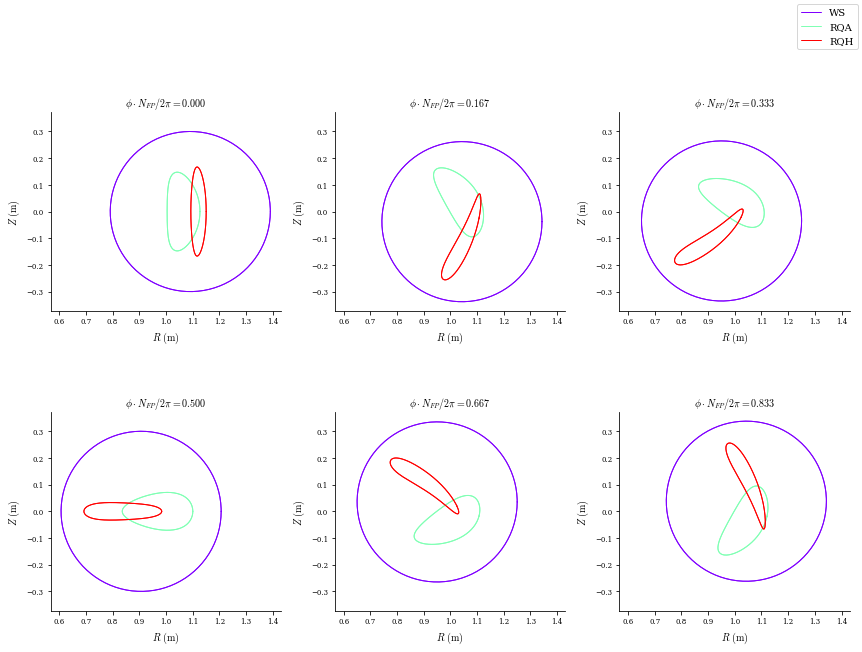

In [9]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [10]:
surf1.I

0.0

In [11]:
surf2.I

0.0

In [12]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [13]:
# Grids
Megrid = 20
Negrid = 20

Msgrid = 20
Nsgrid = 20

egrid = LinearGrid(M=Megrid,N=Negrid,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   NFP=eq.NFP,
                   sym=False) 

In [14]:
surf1.NFP

3

In [15]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [16]:
flux_QA = QuadraticFlux(eq_QA,surf1,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 1,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,surf2,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 1,
                        name="Bn error  eq_QH")

In [17]:
# Distance target
min_QA = 0.1
max_QA = 0.3

min_QH = 0.1
max_QH = 0.28#1#0.28

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 1,
    use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf1,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    use_signed_distance=True,
    weight = 1,
    name="distance error  RQH"
)

In [18]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf1,
    #target = mean_curv,
    bounds = (-1,1),
    weight=1e-2,
    normalize=True,
    normalize_target=True,
    deriv_mode="auto",
    grid=sgrid,
    name="Mean curvature",
)

In [19]:
obj_prin_curv = PrincipalCurvature(surf1,
        #target=None,
        bounds=(-15,-10),
        weight=2e0,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [20]:
Jmax = 5e7 # max current density 50 MA/m2
tmax = 1e-1 # max thickness desired for coils: 10 cm

b_M = 10
b_N = 10

obj_thickness_QA = CoilThicknessRegularization(surf1,
                                               M_b = b_M,
                                               N_b = b_N,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 1,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QA",
                                              )

obj_thickness_QH = CoilThicknessRegularization(surf2,
                                               M_b = b_M,
                                               N_b = b_N,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 1,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QH",
                                              )

In [21]:
obj = ObjectiveFunction((flux_QA,
                         flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         #obj_mean_curv,
                         #obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         obj_thickness_QA,
                         obj_thickness_QH,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    FixParameters(surf2,{"G":True,}),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [22]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [23]:
# Run optimization
(surf1, surf2),_ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=120,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 options={"initial_trust_radius":np.inf})

Building objective: Bn error  eq_QA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 1.36 sec

Building objective: Bn error  eq_QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 44.2 ms

Building objective: distance error  RQA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 134 ms

Building objective: distance error  RQH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 35.2 ms

Building objective: Coil Thickness Regularization: QA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 424 ms

Building objective: Coil Thickness Regularization: QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 74.2 ms

Timer: Objective build = 2.58 sec

Building objective: fixed parameters

Building objective: fixed parameters

Building objective: shared parameters

Timer: Objective build = 78.9 ms

Timer: Linear constraint projection build = 2.89 sec

Number of parameters: 1813

Number of objectives: 10086

Timer: Initializing the optimization = 5.63 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          3.140e+02                                    6.235e+02   

       1              7          3.127e+02      1.258e+00      5.789e+02      6.192e+02   

       2             10          3.126e+02      1.562e-01      7.120e+01      6.186e+02   

       3             11          3.122e+02      3.083e-01      1.422e+02      6.194e+02   

       4             12          3.119e+02      3.541e-01      4.453e+01      6.177e+02   

       5             13          3.112e+02      7.055e-01      8.914e+01      6.144e+02   

       6             14          3.098e+02      1.401e+00      1.786e+02      6.085e+02   

       7             15          3.070e+02      2.765e+00      3.580e+02      5.971e+02   

       8             16          3.016e+02      5.385e+00      7.195e+02      5.764e+02   

       9             17          2.923e+02      9.364e+00      1.360e+03      5.413e+02   

      10             18          2.752e+02      1.705e+01      2.763e+03      4.224e+03   

      11             19          2.707e+02      4.473e+00      6.956e+02      4.739e+02   

      12             20          2.447e+02      2.603e+01      4.231e+03      9.781e+03   

      13             21          2.430e+02      1.704e+00      1.923e+02      7.988e+02   

      14             22          2.025e+02      4.055e+01      7.930e+03      2.469e+03   

      15             23          2.010e+02      1.461e+00      2.571e+02      2.953e+02   

      16             25          1.834e+02      1.763e+01      4.650e+03      1.730e+03   

      17             26          1.814e+02      1.991e+00      5.918e+02      2.427e+02   

      18             27          1.636e+02      1.782e+01      9.859e+03      2.203e+04   

      19             28          1.526e+02      1.093e+01      2.184e+02      5.591e+03   

      20             29          1.502e+02      2.412e+00      2.563e+02      1.330e+03   

      21             30          1.484e+02      1.841e+00      7.331e+02      3.582e+02   

      22             31          1.402e+02      8.156e+00      4.405e+03      3.704e+03   

      23             32          1.384e+02      1.807e+00      1.332e+02      6.548e+02   

      24             33          1.365e+02      1.883e+00      9.424e+02      1.952e+02   

      25             34          1.248e+02      1.176e+01      9.708e+03      9.758e+03   

      26             35          1.206e+02      4.156e+00      1.341e+02      3.281e+03   

      27             36          1.196e+02      1.021e+00      2.006e+02      6.514e+02   

      28             37          1.191e+02      5.140e-01      4.922e+02      8.675e+02   

      29             38          1.187e+02      4.223e-01      1.759e+02      2.374e+02   

      30             40          1.156e+02      3.024e+00      2.856e+03      1.673e+03   

      31             41          1.152e+02      4.417e-01      1.297e+02      2.545e+02   

      32             42          1.132e+02      2.008e+00      1.754e+03      1.271e+02   

      33             43          1.096e+02      3.596e+00      5.852e+03      6.170e+03   

      34             44          1.072e+02      2.405e+00      9.478e+01      1.133e+03   

      35             45          1.067e+02      5.104e-01      2.169e+02      2.782e+02   

      36             46          1.048e+02      1.871e+00      2.069e+03      1.182e+02   

      37             47          1.020e+02      2.770e+00      3.262e+03      6.785e+02   

      38             48          1.017e+02      3.716e-01      2.073e+02      1.160e+02   

      39             49          9.861e+01      3.056e+00      6.769e+03      5.611e+03   

      40             50          9.625e+01      2.367e+00      8.761e+01      8.809e+02   

      41             51          9.569e+01      5.574e-01      2.280e+02      1.769e+02   

      42             52          9.340e+01      2.293e+00      3.236e+03      1.016e+03   

      43             53          9.308e+01      3.171e-01      1.405e+02      4.266e+02   

      44             54          9.268e+01      4.025e-01      3.213e+02      1.086e+02   

      45             55          8.819e+01      4.485e+00      6.963e+03      3.346e+03   

      46             56          8.764e+01      5.544e-01      4.903e+01      1.012e+03   

      47             57          8.723e+01      4.102e-01      2.259e+02      5.200e+02   

      48             58          8.666e+01      5.652e-01      4.959e+02      1.658e+02   

      49             59          8.418e+01      2.482e+00      3.851e+03      1.368e+03   

      50             60          8.382e+01      3.563e-01      1.086e+02      4.780e+02   

      51             61          8.333e+01      4.956e-01      4.412e+02      1.001e+02   

      52             62          7.819e+01      5.136e+00      1.371e+04      7.764e+03   

      53             63          7.502e+01      3.170e+00      9.860e+01      1.773e+03   

      54             64          7.443e+01      5.916e-01      1.719e+02      1.107e+03   

      55             65          7.395e+01      4.831e-01      1.695e+02      2.122e+02   

      56             66          7.244e+01      1.506e+00      2.204e+03      2.635e+02   

      57             67          7.134e+01      1.097e+00      1.590e+03      8.961e+01   

      58             68          6.960e+01      1.740e+00      1.279e+04      9.946e+03   

      59             69          6.580e+01      3.806e+00      9.732e+01      3.786e+03   

      60             70          6.425e+01      1.552e+00      7.369e+01      1.055e+03   

      61             71          6.360e+01      6.422e-01      1.815e+02      2.287e+02   

      62             72          6.266e+01      9.479e-01      1.398e+03      9.125e+01   

      63             73          6.060e+01      2.057e+00      3.289e+03      2.930e+02   

      64             74          6.028e+01      3.219e-01      5.017e+02      1.101e+02   

      65             75          5.730e+01      2.973e+00      5.597e+03      5.069e+02   

      66             76          5.712e+01      1.851e-01      1.022e+02      1.347e+02   

      67             77          5.623e+01      8.905e-01      1.633e+03      1.183e+02   

      68             78          5.472e+01      1.512e+00      2.651e+03      9.219e+01   

      69             79          5.207e+01      2.648e+00      1.065e+04      3.808e+03   

      70             80          5.035e+01      1.719e+00      6.159e+01      1.392e+03   

      71             81          4.969e+01      6.607e-01      8.542e+01      4.615e+02   

      72             82          4.947e+01      2.152e-01      1.431e+02      1.740e+02   

      73             83          4.909e+01      3.787e-01      8.588e+02      9.471e+01   

      74             84          4.810e+01      9.900e-01      2.212e+03      4.355e+02   

      75             85          4.795e+01      1.552e-01      9.026e+01      1.078e+02   

      76             86          4.735e+01      6.028e-01      1.375e+03      5.357e+01   

      77             87          4.612e+01      1.224e+00      3.698e+03      1.081e+03   

      78             88          4.577e+01      3.480e-01      4.891e+01      2.874e+02   

      79             89          4.567e+01      1.057e-01      1.088e+02      6.714e+01   

      80             90          4.436e+01      1.304e+00      3.230e+03      9.693e+01   

      81             91          4.385e+01      5.192e-01      1.155e+03      4.609e+01   

      82             92          4.201e+01      1.835e+00      9.549e+03      3.459e+03   

      83             93          4.050e+01      1.506e+00      4.379e+01      8.844e+02   

      84             94          4.025e+01      2.541e-01      3.345e+01      2.615e+02   

      85             95          4.016e+01      8.868e-02      5.895e+01      7.002e+01   

      86             96          3.986e+01      3.001e-01      6.883e+02      1.053e+02   

      87             97          3.966e+01      2.047e-01      3.334e+02      3.760e+01   

      88             98          3.717e+01      2.490e+00      6.062e+03      6.413e+02   

      89             99          3.698e+01      1.870e-01      5.519e+01      5.595e+02   

      90             100         3.693e+01      4.615e-02      1.933e+01      2.045e+02   

      91             101         3.684e+01      9.820e-02      1.433e+02      1.911e+02   

      92             102         3.679e+01      4.830e-02      2.690e+01      7.107e+01   

      93             103         3.660e+01      1.905e-01      4.750e+02      2.980e+02   

      94             104         3.652e+01      7.646e-02      3.737e+01      9.006e+01   

      95             105         3.645e+01      6.922e-02      1.167e+02      2.917e+01   

      96             107         3.541e+01      1.041e+00      2.564e+03      1.072e+03   

      97             108         3.526e+01      1.536e-01      2.271e+01      2.733e+02   

      98             109         3.523e+01      3.036e-02      3.030e+01      9.161e+01   

      99             110         3.510e+01      1.287e-01      2.128e+02      1.169e+02   

      100            111         3.504e+01      5.372e-02      6.248e+01      2.586e+01   

      101            112         3.389e+01      1.154e+00      4.566e+03      3.651e+03   

      102            113         3.313e+01      7.577e-01      2.253e+01      1.369e+03   

      103            114         3.285e+01      2.774e-01      2.304e+01      3.022e+02   

      104            115         3.280e+01      5.785e-02      4.277e+01      2.578e+02   

      105            116         3.276e+01      3.455e-02      2.330e+01      1.013e+02   

      106            117         3.264e+01      1.189e-01      1.979e+02      1.646e+02   

      107            118         3.260e+01      4.200e-02      2.602e+01      7.851e+01   

      108            119         3.256e+01      4.413e-02      9.482e+01      1.381e+02   

      109            120         3.251e+01      4.388e-02      3.433e+01      2.352e+01   

      110            122         3.213e+01      3.832e-01      6.404e+02      1.657e+02   

      111            123         3.210e+01      3.389e-02      5.093e+01      1.460e+02   

      112            124         3.204e+01      5.508e-02      3.524e+01      4.869e+01   

      113            125         3.197e+01      6.719e-02      1.686e+02      2.257e+02   

      114            126         3.193e+01      4.515e-02      2.325e+01      6.207e+01   

      115            127         3.183e+01      1.016e-01      1.694e+02      1.587e+02   

      116            128         3.179e+01      3.256e-02      3.359e+01      2.310e+01   

      117            129         3.161e+01      1.787e-01      1.320e+03      1.918e+03   

      118            130         3.110e+01      5.166e-01      2.639e+01      5.288e+02   

      119            131         3.098e+01      1.144e-01      2.122e+01      3.496e+02   

      120            132         3.097e+01      8.834e-03      2.209e+01      1.921e+02   

         Current function value: 3.097e+01

         Total delta_x: 1.750e+05

         Iterations: 120

         Function evaluations: 132

         Jacobian evaluations: 121

Timer: Solution time = 8.59 min

Timer: Avg time per step = 4.26 sec

                                                                 Start  -->   End

Total (sum of squares):                                      3.140e+02  -->   3.097e+01, 

Maximum absolute Boundary normal field error:                3.501e-02  -->   3.951e-02 (T m^2)

Minimum absolute Boundary normal field error:                3.129e-17  -->   8.531e-07 (T m^2)

Average absolute Boundary normal field error:                1.035e-02  -->   9.034e-03 (T m^2)

Maximum absolute Boundary normal field error:                3.169e-01  -->   3.576e-01 (normalized)

Minimum absolute Boundary normal field error:                2.832e-16  -->   7.721e-06 (normalized)

Average absolute Boundary normal field error:                9.372e-02  -->   8.177e-02 (normalized)

Maximum absolute Boundary normal field error:                7.879e-02  -->   3.100e-02 (T m^2)

Minimum absolute Boundary normal field error:                2.203e-17  -->   3.908e-06 (T m^2)

Average absolute Boundary normal field error:                2.717e-02  -->   6.497e-03 (T m^2)

Maximum absolute Boundary normal field error:                1.383e+00  -->   5.440e-01 (normalized)

Minimum absolute Boundary normal field error:                3.866e-16  -->   6.858e-05 (normalized)

Average absolute Boundary normal field error:                4.768e-01  -->   1.140e-01 (normalized)

Maximum Plasma-vessel distance:                              3.257e-01  -->   3.351e-01 (m)

Minimum Plasma-vessel distance:                              8.101e-02  -->   7.146e-02 (m)

Average Plasma-vessel distance:                              2.011e-01  -->   1.728e-01 (m)

Maximum Plasma-vessel distance:                              3.169e+00  -->   3.261e+00 (normalized)

Minimum Plasma-vessel distance:                              7.883e-01  -->   6.954e-01 (normalized)

Average Plasma-vessel distance:                              1.957e+00  -->   1.682e+00 (normalized)

Maximum Plasma-vessel distance:                              3.097e-01  -->   2.890e-01 (m)

Minimum Plasma-vessel distance:                              6.063e-02  -->   6.882e-02 (m)

Average Plasma-vessel distance:                              1.994e-01  -->   1.736e-01 (m)

Maximum Plasma-vessel distance:                              3.235e+00  -->   3.018e+00 (normalized)

Minimum Plasma-vessel distance:                              6.333e-01  -->   7.188e-01 (normalized)

Average Plasma-vessel distance:                              2.083e+00  -->   1.814e+00 (normalized)

Maximum Coil Thickness Regularization:                       2.513e+06  -->   5.273e+06 A/m

Minimum Coil Thickness Regularization:                       1.347e+06  -->   7.608e+05 A/m

Average Coil Thickness Regularization:                       1.840e+06  -->   2.508e+06 A/m

Maximum Coil Thickness Regularization:                       4.881e-01  -->   1.024e+00 (normalized)

Minimum Coil Thickness Regularization:                       2.618e-01  -->   1.478e-01 (normalized)

Average Coil Thickness Regularization:                       3.575e-01  -->   4.872e-01 (normalized)

Maximum Coil Thickness Regularization:                       2.600e+06  -->   5.661e+06 A/m

Minimum Coil Thickness Regularization:                       1.394e+06  -->   3.480e+05 A/m

Average Coil Thickness Regularization:                       1.904e+06  -->   2.854e+06 A/m

Maximum Coil Thickness Regularization:                       4.881e-01  -->   1.063e+00 (normalized)

Minimum Coil Thickness Regularization:                       2.618e-01  -->   6.534e-02 (normalized)

Average Coil Thickness Regularization:                       3.575e-01  -->   5.358e-01 (normalized)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

Shared parameters error:                                     0.000e+00  -->   0.000e+00 (~)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

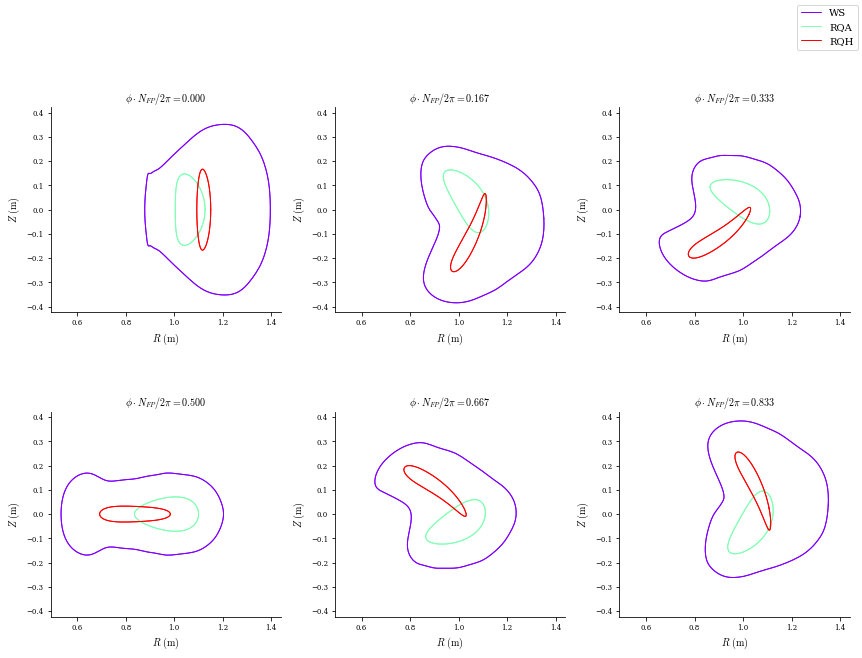

In [24]:
plot_comparison([surf1,
                 eq_QA,
                 eq_QH
                ],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [25]:
#surf1.save("surf_opt.h5")

In [26]:
surf1.I

5.903363251523724e-11

In [27]:
surf2.I

-3827.5434680601493

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

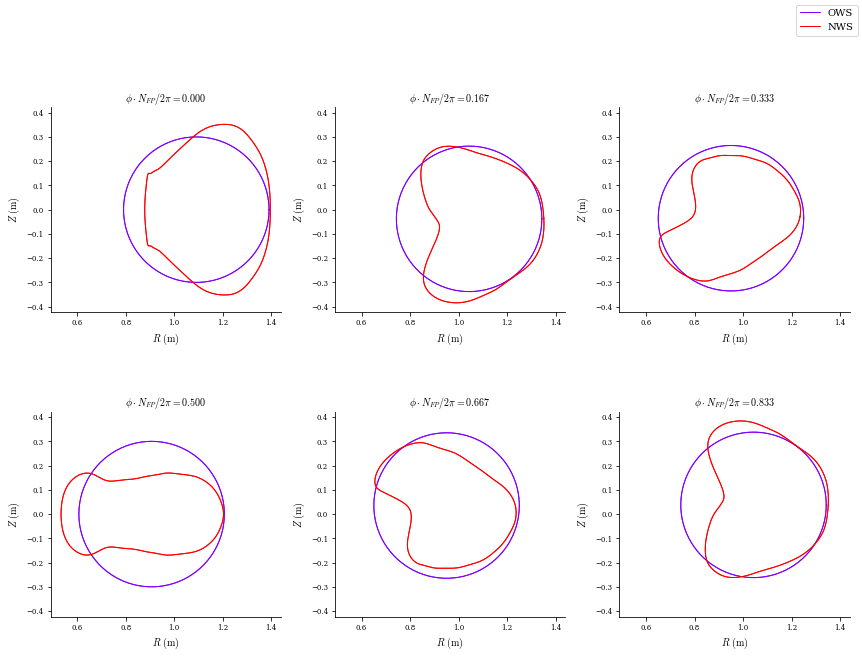

In [28]:
plot_comparison([surf,surf1],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Text(0.5, 1.0, 'K surf2')

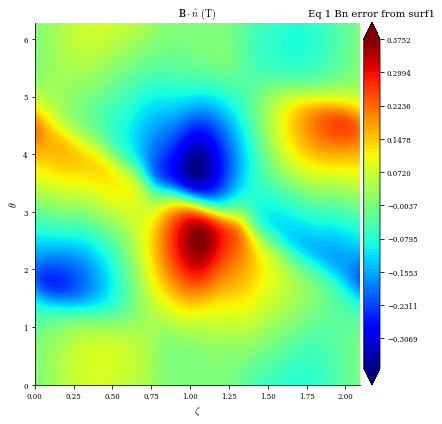

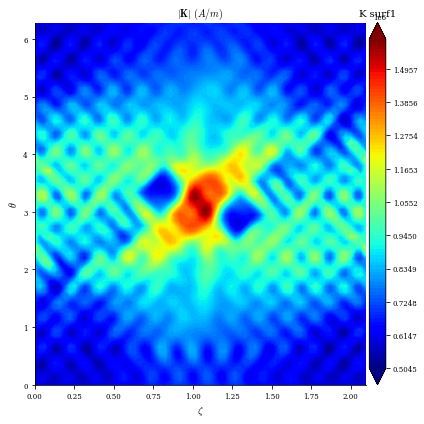

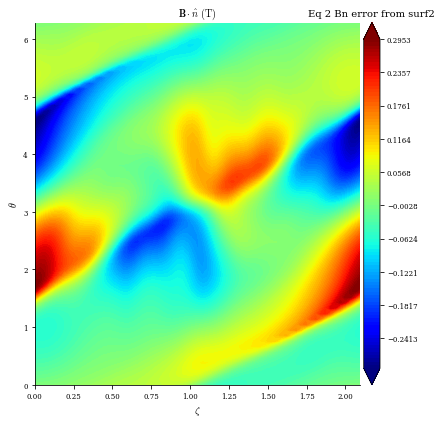

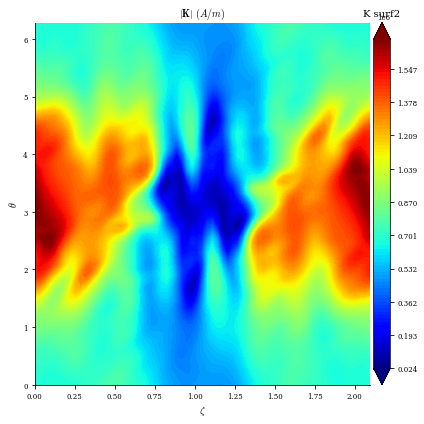

In [29]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=60,N=60,
                                NFP=eq_QA.NFP
                               )
plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "K")
plt.title("K surf1")

plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")

plot_2d(surf2, "K")
plt.title("K surf2")

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

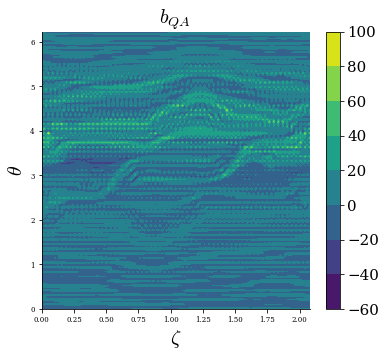

In [30]:
b_QA = surf1.compute("b_s",grid = denser_source_grid)["b_s"]

plot_figure2(b_QA,
            denser_source_grid,
            ''r'$b_{QA}$ '
           )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

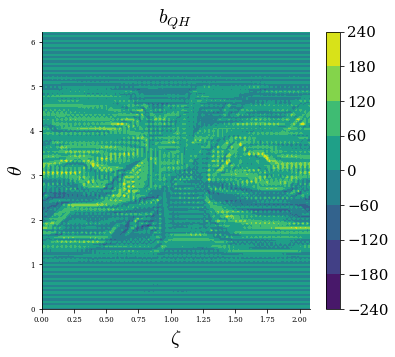

In [31]:
b_QH = surf2.compute("b_s",grid = denser_source_grid)["b_s"]

plot_figure2(b_QH,
            denser_source_grid,
            ''r'$b_{QH}$ '
           )